# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

# 1D example

In [3]:
def f_1d_toy(x):
    if 2 <= x.item() <= 3:
        f = \
            -1600 * (x - 2.5) ** 5 - \
            2000 * (x - 2.5) ** 4 + \
            800 * (x - 2.5) ** 3 + \
            1020 * (x - 2.5) ** 2 

    elif 8.4 <= x.item() <= 8.40001:
        f = 1411.2 * (1 - 1e4 * (x - 8.4))

    elif 8.40001 <= x.item() <= 8.59999:

        f = x * 0

    elif 8.59999 <= x.item() <= 8.6:
        f = 1479.2 * (1e4 * (x - 8.6) + 1)

    else:
        f = 20 * x ** 2

    return f

In [4]:
xs = np.arange(-2, 10, 1e-3)
xs_torch = [torch.tensor([x]) for x in xs]
ys_torch = [f_1d_toy(x) for x in xs_torch]
ys = [y.item() for y in ys_torch]

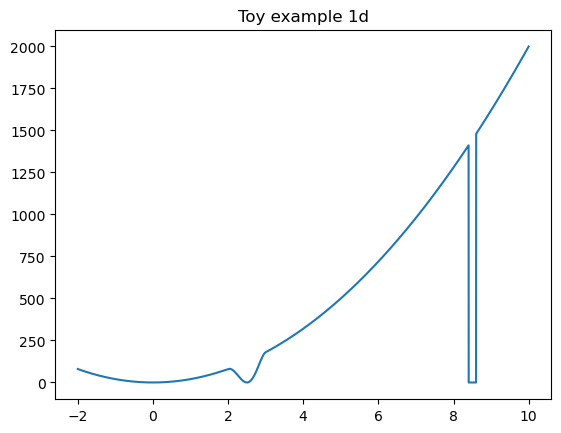

In [5]:
plt.plot(xs, ys)
plt.title('Toy example 1d')
plt.show()

In [6]:
torch.ones_like(torch.zeros(3)) * 0 / 0

tensor([nan, nan, nan])

In [7]:
def run_gd(func, lr, x_start_value, max_iter, return_null_if_fail=False):
    x = torch.tensor(x_start_value, requires_grad=True)
    optimizer = optim.SGD([x], lr=lr)
    x_hist_torch = []

    n_iter = 0

    while len(x_hist_torch) == 0 or \
        torch.norm(x - x_hist_torch[-1]) > 1e-6 and \
        n_iter < max_iter:

        x_hist_torch.append(x.detach().clone())

        optimizer.zero_grad()
        func(x).backward()

        optimizer.step()
        n_iter += 1

    x_hist_torch.append(x.detach().clone())

    if n_iter >= max_iter and return_null_if_fail:
        x_hist_torch.append(torch.zeros_like(x) / 0)

    return x_hist_torch

In [8]:
def plot_1d_gd(lr, start_point, max_iter=1e3):

    xs = np.arange(-2, 10, 1e-3)
    xs_torch = [torch.tensor([x]) for x in xs]
    ys_torch = [f_1d_toy(x) for x in xs_torch]
    ys = [y.item() for y in ys_torch]
    
    plt.style.use('default')
    plt.plot(xs, ys)

    x_hist_torch = run_gd(f_1d_toy, lr, [start_point], max_iter)
    y_hist_torch = [f_1d_toy(x) for x in x_hist_torch]
    x_hist = [x.item() for x in x_hist_torch]
    y_hist = [y.item() for y in y_hist_torch]

    plt.style.use('seaborn-dark-palette')
    plt.scatter(x_hist, y_hist, c=range(len(x_hist)))
    plt.title(f'Toy example 1d lr={lr}')
    plt.show()

/tmp/ipykernel_26547/3409896591.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


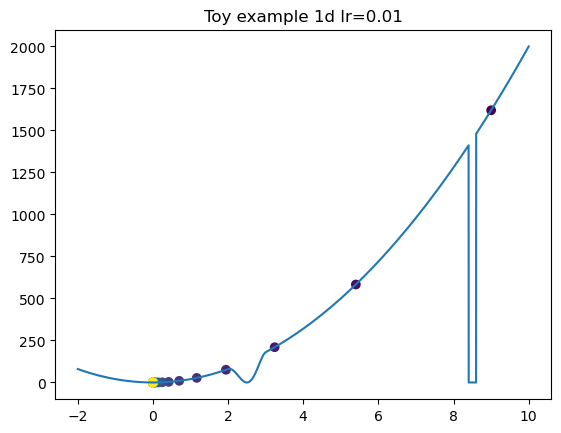

/tmp/ipykernel_26547/3409896591.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


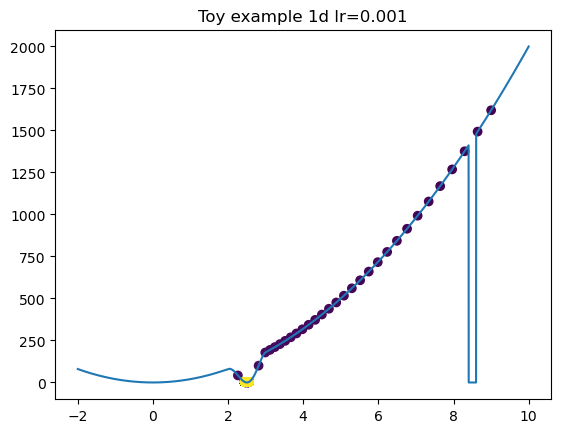

/tmp/ipykernel_26547/3409896591.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


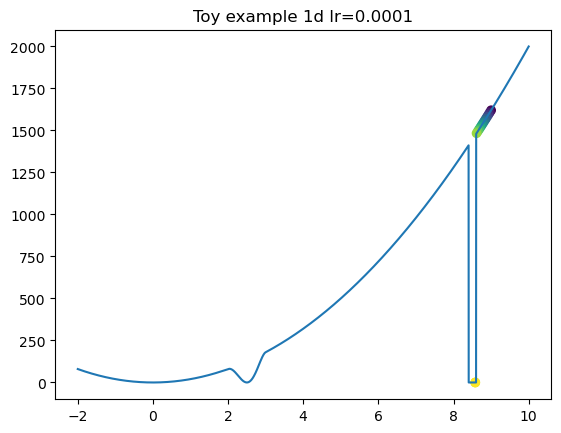

In [9]:
plot_1d_gd(1e-2, 9.)
plot_1d_gd(1e-3, 9.)
plot_1d_gd(1e-4, 9.)

In [10]:
import scipy.stats as ss
from itertools import product
from tqdm.notebook import tqdm
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import pandas as pd

In [11]:
lrs = np.logspace(-4, 0, 25)
x_starts = np.linspace(8.5, 10, 20)
x_ends = np.zeros((len(lrs), len(x_starts)), dtype=float)

for (lr_i, lr), (x_start_i, x_start) in tqdm(
    product(enumerate(lrs), enumerate(x_starts))
):
    x_ends[lr_i, x_start_i] = run_gd(f_1d_toy, lr, [x_start], 1e3, return_null_if_fail=True)[-1].item()


0it [00:00, ?it/s]

In [12]:
x_ends_df = pd.DataFrame(x_ends, columns=x_starts).assign(lrs=lrs)
x_ends_df = x_ends_df.melt(id_vars='lrs', var_name='x_start', value_name='x_end')
x_ends_df

,lrs,x_start,x_end
0,0.000100,8.5,8.5
1,0.000147,8.5,8.5
2,0.000215,8.5,8.5
3,0.000316,8.5,8.5
4,0.000464,8.5,8.5
...,...,...,...
495,0.215443,10.0,NaN
496,0.316228,10.0,NaN
497,0.464159,10.0,NaN
498,0.681292,10.0,NaN


In [13]:
def x_end_to_type(x):
    if np.isnan(x):
        return 'No convergence in 1000 iterations'

    if -1e-2 < x < 1e-2:
        return 'global min'
    
    elif -1e-2 < x - 2.5 < 1e-2:
        return 'local min'
    
    elif -8.4 < x < 8.6:
        return 'sharp local min near start'

    else:
        return 'something else' 


x_ends_df['x_end_type'] = x_ends_df['x_end'].apply(x_end_to_type)

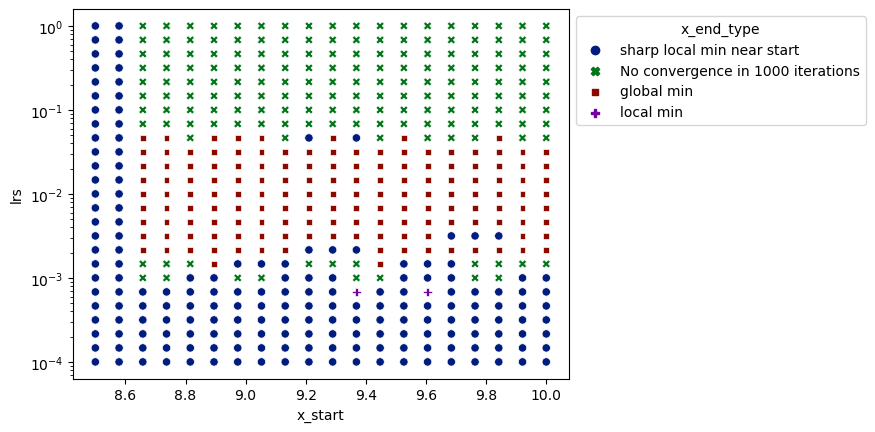

In [14]:
ax = sns.scatterplot(
    data=x_ends_df, 
    x='x_start', 
    y='lrs', 
    hue='x_end_type', 
    style='x_end_type',
)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.yscale('log')
plt.show()

# 2D example

In [15]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [16]:
import torch.nn.functional as F

In [17]:
def f_2d_toy(x, y):
    f_A = x ** 2 + y ** 2
    f_B = 200 * \
        F.relu(torch.abs(x) - 1) * \
        F.relu(torch.abs(y) - 1) * \
        F.relu(2 - torch.abs(x)) * \
        F.relu(2 - torch.abs(y))

    return f_A - f_B

In [18]:
x = torch.linspace(-3, 3, 40)
y = torch.linspace(-3, 3, 40)

grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')

In [19]:
grid_z = f_2d_toy(grid_x, grid_y)

In [20]:
x_hist = run_gd(lambda x: f_2d_toy(x[0], x[1]), 0.05, [3., 2.5], max_iter=1e5)
xs = np.array([x[0].item() for x in x_hist])
ys = np.array([x[1].item() for x in x_hist])
zs = f_2d_toy(torch.tensor(xs), torch.tensor(ys)).numpy()

In [21]:
fig = go.Figure(
    data=[
        go.Surface(
            x=grid_x.numpy(), 
            y=grid_y.numpy(), 
            z=grid_z.numpy(), 
            colorscale='Viridis', 
            showscale=False
        ),
        go.Scatter3d(
            x=xs, y=ys, z=zs,
        )
    ],
)

fig.update_layout(
    title={
        'text': f'GD converged to flat minima lr=0.01', 
        'x':0.5,
        'xanchor': 'center',
    }
)

fig.show()

In [22]:
x_hist = run_gd(lambda x: f_2d_toy(x[0], x[1]), 0.005, [3., 2.5], max_iter=1e4)
xs = np.array([x[0].item() for x in x_hist])
ys = np.array([x[1].item() for x in x_hist])
zs = f_2d_toy(torch.tensor(xs), torch.tensor(ys)).numpy()
fig = go.Figure(
    data=[
        go.Surface(
            x=grid_x.numpy(), 
            y=grid_y.numpy(), 
            z=grid_z.numpy(), 
            colorscale='Viridis', 
            showscale=False
        ),
        go.Scatter3d(
            x=xs, y=ys, z=zs,
        )
    ]
)

fig.update_layout(
    title={
        'text': f'GD converged to sharp minima lr=0.005', 
        'x':0.5,
        'xanchor': 'center',
    }
)


fig.show()

In [25]:
lrs = np.logspace(-1.75, -1.6, 10)

x_starts = np.random.uniform(3, 4, size=(10, 2))
x_ends = np.zeros((len(lrs), len(x_starts), 2), dtype=float)
z_ends = np.zeros((len(lrs), len(x_starts)), dtype=float)


for (lr_i, lr), (x_start_i, x_start) in tqdm(
    product(enumerate(lrs), enumerate(x_starts))
):
    ends = run_gd(lambda x: f_2d_toy(x[0], x[1]), lr, x_start, 1e3)[-1]
    x_ends[lr_i, x_start_i] = ends.numpy()
    z_ends[lr_i, x_start_i] = f_2d_toy(ends[0], ends[1]).item()


0it [00:00, ?it/s]

In [26]:
z_ends_df = pd.DataFrame(z_ends, columns=[f'x_start_{i}' for i in range(len(x_starts))])
z_ends_df['lr'] = lrs

In [27]:
z_ends_df = z_ends_df.melt(id_vars='lr', value_vars=[f'x_start_{i}' for i in range(len(x_starts))])

In [28]:
z_ends_df['log_lr'] = np.log10(z_ends_df['lr']).astype(int)

In [29]:
# sns.histplot(data=z_ends_df, x='value', hue='log_lr', palette='tab10', fill=False)
# plt.show()

In [30]:
def map_val_to_type(z):
    if z < -8:
        return 'sharp minima'

    elif -1e-2 < z < 1e-2:
        return 'flat minima'
    
    else:
        return 'did not converge'

z_ends_df['type_minima'] = z_ends_df['value'].apply(map_val_to_type)

In [31]:
ends_counts = (z_ends_df
    .groupby('lr')
    ['type_minima']
    .value_counts()
    .to_frame()
    .set_axis(['counts'], axis=1)
    .reset_index()
)

ends_counts['fraction'] = ends_counts.groupby('lr')['counts'].transform(lambda s_: s_/s_.sum())

In [32]:
# frac_counter = z_ends_df.query('type_gd == "flat minima"').groupby('lr').size() / z_ends_df.groupby('lr').size()
# frac_counter.fillna(0, inplace=True)
# frac_counter = frac_counter.to_frame(name='fraction of flat minima').reset_index()a

In [33]:
ends_counts = ends_counts.merge(
    pd.merge(
        ends_counts[['lr']].drop_duplicates(), 
        ends_counts[['type_minima']].drop_duplicates(),
        how='cross'
    ),
    on=['lr', 'type_minima'],
    how='outer'
).fillna(0)

In [40]:
ends_counts.sort_values('lr', inplace=True)

In [42]:
px.line(data_frame=ends_counts, x='lr', y='fraction', color='type_minima', line_dash='type_minima')

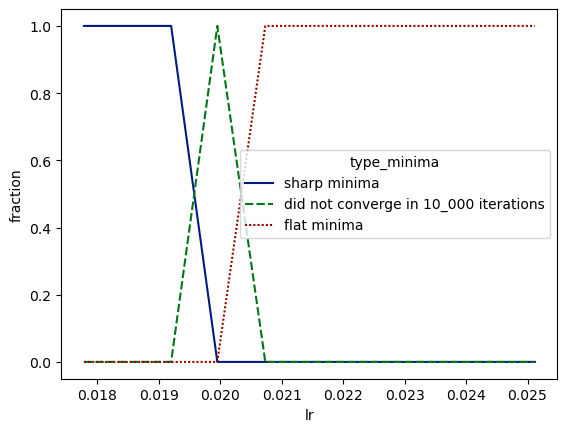

In [34]:
sns.lineplot(data=ends_counts, x='lr', y='fraction', hue='type_minima', style='type_minima')
# sns.scatterplot(data=ends_counts, x='lr', y='fraction')
# plt.xscale('log')
plt.show()

# NN example

In [ ]:
import seaborn_image as isns
from torch import nn

In [ ]:
torch.cuda.is_available()

In [ ]:
device = torch.device("cuda")

# Mnist

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 100
trainset = torchvision.datasets.MNIST(
    root='./data/', 
    train=True, 
    download=True, 
    transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=2
)

testset = torchvision.datasets.MNIST(
    root='./data/', 
    train=False, 
    download=True, 
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=2
)

In [ ]:
rows, cols = 3, 3
fig, axs = plt.subplots(rows, cols, figsize=(8, 8))

for i, j in product(range(rows), range(cols)):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    sample_img , sample_lbl = trainset[sample_idx]

    axs[i, j].set_title(sample_lbl)
    isns.imgplot(sample_img.numpy()[0][::-1], ax=axs[i, j], cbar=False)

plt.show()

In [ ]:
class MyLittleNN(nn.Module):
    def __init__(self):
        super(MyLittleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 10)
            ## Softmax layer ignored since the loss function defined is nn.CrossEntropy()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    

In [ ]:
def train_epoch(dataloader, model, loss_fn, optimizer, path_length=None):
    model.train()

    if path_length is not None:
        params_hist = []
        params_nbatches = len(dataloader) // path_length


    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

        if path_length is not None and batch % params_nbatches == 0:
            params_hist.append( 
                # np.concatenate([p.cpu().detach().numpy().reshape(-1) for p in model.parameters()]) 
                next(model.parameters()).cpu().detach().numpy().reshape(-1)
            )

    if path_length is not None:
        return params_hist
        

In [ ]:
def validation(dataloader, model, loss_fn):
    size = 0
    correct = 0
    loss = 0

    model.eval()

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            size += len(y)

            pred = model(X)
            loss += loss_fn(pred, y).item()

            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    return loss, correct / size

In [ ]:
def train(trainloader, testloader, model, loss_fn, optimizer, epochs, path_length):
    
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    params_hist = []

    for epoch in range(epochs):
        print(f'EPOCH {epoch}')
        
        print('TRAIN')
        _param_hist = train_epoch(trainloader, model, loss_fn, optimizer, path_length // epochs)

        params_hist += _param_hist

        _train_loss, _train_accuracy = validation(trainloader, model, loss_fn)
        _test_loss, _test_accuracy = validation(testloader, model, loss_fn)

        print(f'TRAIN loss {_train_loss:.2f} accuracy {_train_accuracy:.2f}')
        print(f'TEST loss {_test_loss:.2f} accuracy {_test_accuracy:.2f}')

        train_loss.append(_train_loss)
        train_accuracy.append(_train_accuracy)
        test_loss.append(_test_loss)
        test_accuracy.append(_test_accuracy)

    return train_loss, train_accuracy, test_loss, test_accuracy, params_hist


In [ ]:
strategies = {
    'A': [
        (1e-3, 5, 50),
        (1e-1, 1, 50),
    ],
    'B': [
        (1e-1, 1, 50),
        (1e-3, 5, 50),
    ]
}

In [ ]:
loss_fn = nn.CrossEntropyLoss()

params_df = []
losses_df = []

for name, strategy in strategies.items():
    torch.manual_seed(42)
    model = MyLittleNN().to(device)

    for lr, epochs, path_length in strategy:
        
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)

        train_loss, train_accuracy, test_loss, test_accuracy, params_hist = train(
            trainloader, 
            testloader, 
            model, 
            loss_fn, 
            optimizer, 
            epochs=epochs, 
            path_length=path_length
        )

        losses_df.append(
            pd.DataFrame({
                'strategy_name': name,
                'lr': lr,
                'train_loss': train_loss, 
                'test_loss': test_loss, 
                'train_acc': train_accuracy,
                'test_acc': test_accuracy
            })
        )

        params_df.append(
            pd.DataFrame(
                data=params_hist, 
                columns=[f'param_{i + 1}' for i in range(len(params_hist[0]))]
            ).assign(strategy_name=name, lr=lr)
        )



In [ ]:
losses_df = pd.concat(losses_df)
params_df = pd.concat(params_df)

In [ ]:
losses_df['step'] = losses_df.groupby('strategy_name')['lr'].transform(lambda s_: np.arange(len(s_)) + 1)
params_df['step'] = params_df.groupby('strategy_name')['lr'].transform(lambda s_: np.arange(len(s_)) + 1)

In [ ]:
import copy 
copy.deepcopy(model)

In [ ]:
params_hist_df = []
for lr, params in params_hist.items():
    params_hist_df.append(
        pd.DataFrame(
            data=params, 
            columns=[f'param_{i + 1}' for i in range(len(params[0]))]
        ).assign(lr=lr)
    )

params_hist_df = pd.concat(params_hist_df)

In [ ]:
params_hist_df.reset_index(inplace=True)
params_hist_df.rename(columns={'index': 'step'}, inplace=True)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
len(params_hist_df)

In [ ]:
pca = PCA(n_components=2)
X = pca.fit_transform(params_hist_df.drop(['lr', 'step'], axis=1))

In [ ]:
pca.explained_variance_ratio_

In [ ]:
params_hist_df.query('step == 0')

In [ ]:
plt.title('parameter std distribution')
params_hist_df.drop(['step', 'lr'], axis=1).std(axis=0).hist()
plt.show()

In [ ]:
sns.lineplot(
    x=X[:, 0], 
    y=X[:, 1], 
    hue=params_hist_df['lr'],
)

plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [ ]:
params_hist_df.to_parquet('params_hist.parquet')